In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

### Data Collection

In [49]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv


In [50]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

### Data analysis

In [51]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
# Duplicates (data.duplicated().sum())
# Missing values (data.isnull().sum())
# Categorical
# Outliers
# Feature Engineering
# Feature Selection and/or Dimensionality Reduction

In [52]:
data = pd.concat([df_train, df_test], axis=0)

In [53]:
df_train.shape

(1909, 16)

In [54]:
df_test.shape

(365, 15)

In [55]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [56]:
data['date'] = pd.to_datetime(data['date'])

In [57]:
data['wind_speed']

0      27.74 km/h
1      21.78 km/h
2        6.83 m/s
3        5.79 m/s
4      25.14 km/h
          ...    
360    22.78 km/h
361    18.33 km/h
362      7.24 m/s
363      7.67 m/s
364    30.99 km/h
Name: wind_speed, Length: 2274, dtype: object

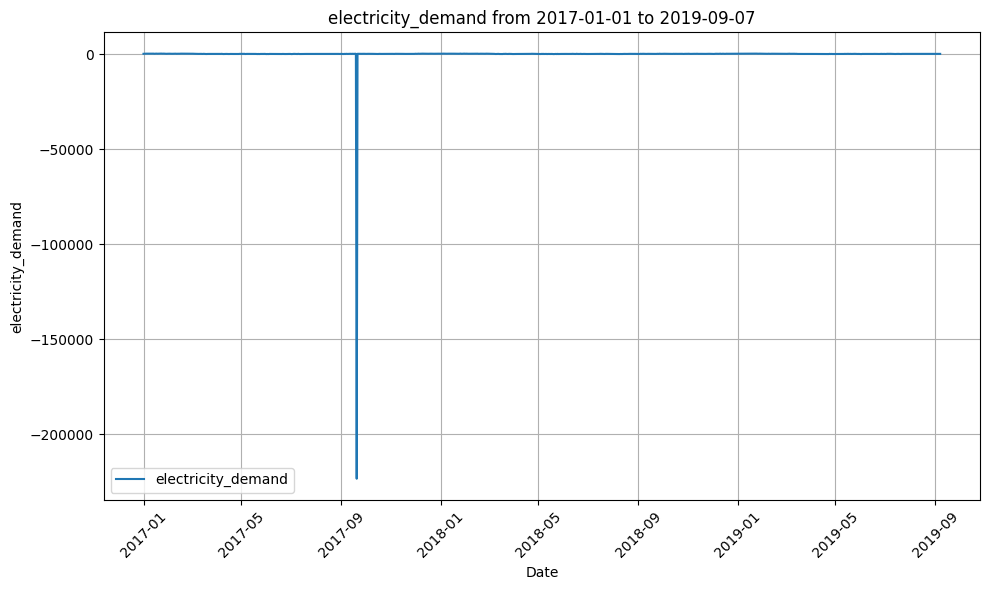

In [58]:
plot_feature_over_time(data, 'electricity_demand', '2017-01-01', '2019-09-07')

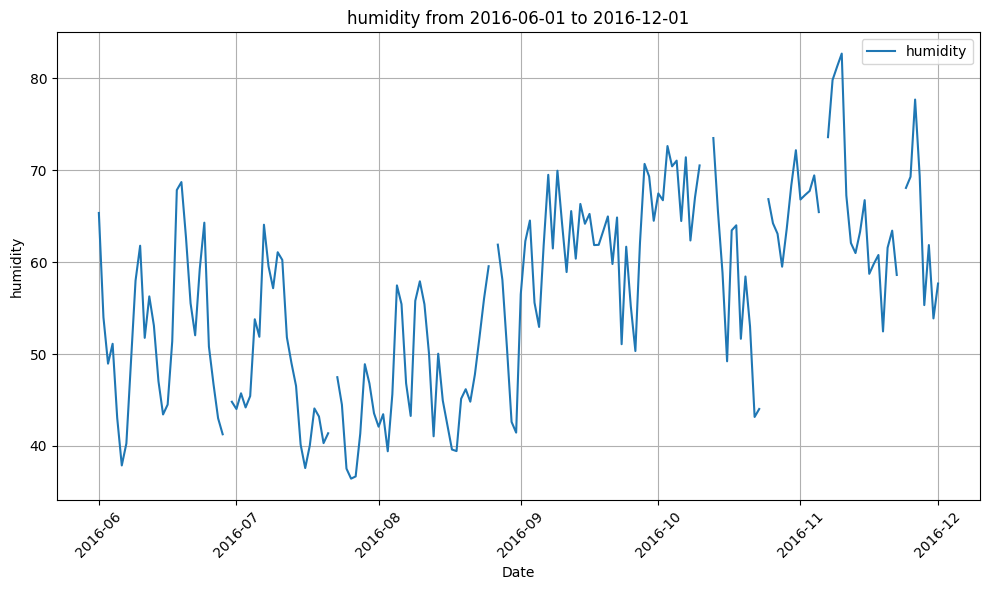

In [59]:
plot_feature_over_time(data, 'humidity', '2016-06-01', '2016-12-01')

### Data Preprocessing Evaluation Strategy

In [60]:
display(data)

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


In [61]:
data2=data.copy()

In [62]:
print(data["weather_condition"].unique().tolist()) 
#display(data[data["weather_condition"].isna()])
print(data["oil_brent_price_indicator"].unique().tolist()) 

['Cloudy', 'Sunny', 'Rainy', 'Snowy', nan]
['Moderate', 'High', 'Low', 'Very Low', 'Very High']


In [64]:

import re

# Conversion robuste d'une valeur de vitesse de vent vers km/h (float)
def wind_speed_convert(value):
    # Déjà manquant
    if pd.isna(value):
        return np.nan

    # Déjà numérique
    if isinstance(value, (int, float, np.integer, np.floating)):
        return float(value)

    s = str(value).strip().lower()

    # Regex: nombre + unité optionnelle (km/h, kmh, m/s, ms)
    m = re.match(r'^([+-]?\d+(?:\.\d+)?)\s*(km/?h|kmh|m/?s|ms)?$', s)
    if not m:
        return np.nan

    num = float(m.group(1))
    unit = m.group(2)

    if unit is None or unit in ("km/h", "kmh", "kmh", "km/h"):
        return num
    if unit in ("m/s", "ms", "m/s"):
        return num * 3.6

    # Par sécurité
    return np.nan

# Harmonisé: toujours (X, y) ou (X_tr, y_tr, X_val, y_val)
def handle_inconsistencies(X, y, X_val=None, y_val=None):
    X = X.copy()
    if "wind_speed" in X.columns:
        X["wind_speed"] = X["wind_speed"].apply(wind_speed_convert)
        X["wind_speed"] = pd.to_numeric(X["wind_speed"], errors="coerce")

    if X_val is None:
        return X, y

    X_val = X_val.copy()
    if "wind_speed" in X_val.columns:
        X_val["wind_speed"] = X_val["wind_speed"].apply(wind_speed_convert)
        X_val["wind_speed"] = pd.to_numeric(X_val["wind_speed"], errors="coerce")

    return X, y, X_val, y_val


In [ ]:
def handle_duplicates(X, y, X_val=None, y_val=None, subset=None, keep="first"):

    # Train
    X2 = X.drop_duplicates(subset=subset, keep=keep)
    y2 = y.loc[X2.index]

    if X_val is None:
        return X2, y2

    # Val
    Xv2 = X_val.drop_duplicates(subset=subset, keep=keep)
    yv2 = None if y_val is None else y_val.loc[Xv2.index]

    return X2, y2, Xv2, yv2


In [67]:
''' 
#Traitement des valeurs manquantes 

import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(df_no_exact_dupes.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Values')
plt.show()
'''

" \n#Traitement des valeurs manquantes \n\nimport seaborn as sns\nplt.figure(figsize=(12, 8))\nsns.heatmap(df_no_exact_dupes.isnull(), cbar=False, cmap='viridis')\nplt.title('Heatmap of Missing Values')\nplt.show()\n"

In [69]:


def _coerce_numeric(df: pd.DataFrame, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df
def data_cleaner(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df.copy()

    # S'assurer que 'humidity' et 'wind_speed' sont numériques
    df_clean = _coerce_numeric(df_clean, ["humidity", "wind_speed"])

    # Colonnes de température → s'assurer que c'est numérique puis interpolation
    cols_temp = [c for c in df_clean.columns if c.startswith("temperature_station")]
    if cols_temp:
        df_clean = _coerce_numeric(df_clean, cols_temp)
        # Interpolation linéaire, dans les deux sens si trous en début/fin
        df_clean[cols_temp] = df_clean[cols_temp].interpolate(
            method="linear", limit_direction="both"
        )

    # NE PAS supprimer les lignes avec weather_condition manquant ici.
    # On traitera ça dans handle_categorical (fillna("Unknown")).

    return df_clean
def handle_missing_values(X, y, X_val=None, y_val=None):
    # Nettoyage de base (types + interpolation températures)
    X = data_cleaner(X)

    # Médianes calculées sur le TRAIN uniquement
    medians = {}
    for col in ("humidity", "wind_speed"):
        if col in X.columns:
            medians[col] = X[col].median()

    # Imputation TRAIN
    for col, m in medians.items():
        X[col] = X[col].fillna(m)

    if X_val is None:
        return X, y

    # Apply sur VAL/TEST en utilisant les médianes du TRAIN (pas de fuite)
    X_val = data_cleaner(X_val)
    for col, m in medians.items():
        if col in X_val.columns:
            X_val[col] = X_val[col].fillna(m)

    return X, y, X_val, y_val


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
import inspect

def Encodage_var_cat(df):
    df = df.copy()
    df["weather_condition"] = df["weather_condition"].fillna("Unknown")

    # Vérifie si le paramètre 'sparse_output' existe dans la version installée
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    else:
        ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

    X_w = ohe.fit_transform(df[["weather_condition"]])
    # Récupère les noms des features encodées
    cols = ohe.get_feature_names_out(["weather_condition"])
    df_encoded = pd.DataFrame(X_w, columns=cols, index=df.index)

    # Remplace la colonne d'origine par les colonnes encodées
    df = df.drop(columns=["weather_condition"])
    df = pd.concat([df, df_encoded], axis=1)

    return df


def handle_categorical(X, y, X_val=None, y_val=None):
    """
    - Fit OHE 'weather_condition' sur le TRAIN, transform sur VAL/TEST
    - Map 'oil_brent_price_indicator' en ordinal et supprime la colonne d'origine
    - Retourne (X, y) ou (X_tr, y_tr, X_val, y_val) avec colonnes alignées
    """
    def _fit_ohe_on_train_and_transform(X_tr, X_to):
        X_tr = X_tr.copy()
        X_to = X_to.copy()

        # weather_condition -> OHE
        if "weather_condition" in X_tr.columns:
            X_tr["weather_condition"] = X_tr["weather_condition"].fillna("Unknown")
            X_to["weather_condition"] = X_to["weather_condition"].fillna("Unknown") if "weather_condition" in X_to.columns else "Unknown"

            ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")
            ohe.fit(X_tr[["weather_condition"]])

            Xw_tr = ohe.transform(X_tr[["weather_condition"]])
            Xw_to = ohe.transform(X_to[["weather_condition"]])

            try:
                w_cols = ohe.get_feature_names_out(["weather_condition"])
            except AttributeError:
                w_cols = ohe.get_feature_names(["weather_condition"])

            W_tr = pd.DataFrame(Xw_tr, columns=w_cols, index=X_tr.index)
            W_to = pd.DataFrame(Xw_to, columns=w_cols, index=X_to.index)

            X_tr = pd.concat([X_tr.drop(columns=["weather_condition"]), W_tr], axis=1)
            X_to = pd.concat([X_to.drop(columns=["weather_condition"], errors="ignore"), W_to], axis=1)

        # oil_brent_price_indicator -> ordinal + drop
        order = ["Very Low", "Low", "Moderate", "High", "Very High"]
        for Z in (X_tr, X_to):
            if "oil_brent_price_indicator" in Z.columns:
                cat = pd.Categorical(Z["oil_brent_price_indicator"], categories=order, ordered=True)
                Z["oil_indicator_ord"] = pd.Series(cat.codes, index=Z.index).astype("Int64")
                Z.drop(columns=["oil_brent_price_indicator"], inplace=True)

        # Alignement final (sécurité)
        X_to = X_to.reindex(columns=X_tr.columns, fill_value=0)

        return X_tr, X_to

    # --- Cas sans validation ---
    if X_val is None:
        X_enc, _ = _fit_ohe_on_train_and_transform(X, X)  # fit + self-transform
        return X_enc, y

    # --- Cas avec validation ---
    X_tr_enc, X_val_enc = _fit_ohe_on_train_and_transform(X, X_val)
    return X_tr_enc, y, X_val_enc, y_val


In [72]:
'''
#Outliers
for column in df_ohe.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_ohe[column])
    plt.title('Box Plot for Outlier Detection')
    plt.show()
'''

"\n#Outliers\nfor column in df_ohe.columns:\n    plt.figure(figsize=(10, 6))\n    sns.boxplot(x=df_ohe[column])\n    plt.title('Box Plot for Outlier Detection')\n    plt.show()\n"

In [74]:
#print(list(df_ohe.columns))

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Feature engineering 
def basic_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Date → composantes temps + encodage cyclique
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df["hour"] = df["date"].dt.hour
        df["dayofweek"] = df["date"].dt.dayofweek  # 0=lundi, 6=dimanche
        df["month"] = df["date"].dt.month
        df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

        # Encodage cyclique 
        # heure sur 24h
        df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24.0)
        df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24.0)
        # jour de semaine sur 7
        df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7.0)
        df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7.0)
        # mois sur 12
        df["month_sin"] = np.sin(2 * np.pi * (df["month"] - 1) / 12.0)
        df["month_cos"] = np.cos(2 * np.pi * (df["month"] - 1) / 12.0)

    #  Températures des stations → agrégats simples
    temp_cols = [c for c in df.columns if c.startswith("temperature_station")]
    if temp_cols:
        df["temp_mean"] = df[temp_cols].mean(axis=1)
        df["temp_min"]  = df[temp_cols].min(axis=1)
        df["temp_max"]  = df[temp_cols].max(axis=1)
        df["temp_std"]  = df[temp_cols].std(axis=1)
        df["temp_range"] = df["temp_max"] - df["temp_min"]

    #  Vent / humidité :
    for col in ["wind_speed", "humidity"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Indicateur pétrole (ordinal)
    if "oil_brent_price_indicator" in df.columns:
        order = ["Very Low", "Low", "Moderate", "High", "Very High"]
        cat = pd.Categorical(df["oil_brent_price_indicator"], categories=order, ordered=True)
        df["oil_indicator_ord"] = pd.Series(cat.codes, index=df.index).astype("Int64")

    #  Météo (dummies déjà présentes) → petit regroupement simple
    #     Indicateur précipitations (Rainy ou Snowy)
    rain_col = "weather_condition_Rainy"
    snow_col = "weather_condition_Snowy"
    if rain_col in df.columns or snow_col in df.columns:
        df["is_precip"] = (df.get(rain_col, 0) + df.get(snow_col, 0) > 0).astype(int)

    return df


# 2) PCA pour réduction + ranking des features d’origine
def pca_feature_selection(
    df: pd.DataFrame,
    target_col: str = "electricity_demand",
    variance_threshold: float = 0.95,
    top_k: int = 15
):

    # Colonnes à exclure des features
    exclude_cols = {"date", target_col, "oil_brent_price_indicator"}  # on garde 'oil_indicator_ord' si présent
    # On ne garde que numériques
    candidate_cols = [c for c in df.columns if c not in exclude_cols]
    X_num = df[candidate_cols].select_dtypes(include=[np.number]).copy()

    # Gestion basique des manquants
    X_num = X_num.fillna(X_num.median(numeric_only=True))

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_num)

    # PCA non bornée, puis choix des composantes via seuil de variance cumulée
    pca = PCA(n_components=None, svd_solver="auto", random_state=42)
    X_pca_full = pca.fit_transform(X_scaled)

    cumvar = np.cumsum(pca.explained_variance_ratio_)
    k = int(np.searchsorted(cumvar, variance_threshold) + 1)

    # Transformation finale avec k composantes
    pca_k = PCA(n_components=k, svd_solver="auto", random_state=42)
    X_pca = pca_k.fit_transform(X_scaled)

    # Ranking des features d'origine par contribution:
    # score(feature j) = somme_{i=1..k} |loading_{i,j}| * explained_var_ratio_{i}
    loadings = pca_k.components_  # shape (k, n_features)
    evr = pca_k.explained_variance_ratio_  # shape (k,)
    contrib = np.abs(loadings) * evr[:, None]  # pondération par variance expliquée
    scores = contrib.sum(axis=0)  # importance agrégée par feature

    feature_scores = pd.Series(scores, index=X_num.columns).sort_values(ascending=False)
    selected_features = feature_scores.head(top_k).index.tolist()

    info = {
        "n_features_in": X_num.shape[1],
        "n_components": k,
        "explained_variance_ratio_cum": float(cumvar[k-1]),
        "top_features": feature_scores.head(top_k)
    }

    return X_pca, selected_features, feature_scores, info


# 6. Feature Engineering
def feature_engineering(X_train: pd.DataFrame, y_train, X_val: pd.DataFrame = None):
    X_train_fe = basic_feature_engineering(X_train)
    if X_val is not None:
        X_val_fe = basic_feature_engineering(X_val)
        return X_train_fe, y_train, X_val_fe
    else:
        return X_train_fe, y_train


# 7. Feature Selection and Dimensionality Reduction (via PCA-ranking)
def feature_selection(X_train: pd.DataFrame, y_train, X_val: pd.DataFrame = None,
                      variance_threshold: float = 0.95, top_k: int = 15):
    # On réutilise pca_feature_selection qui attend la cible dans le DataFrame :
    df_train_tmp = X_train.copy()
    df_train_tmp["electricity_demand"] = y_train

    # Appel à la fonction déjà créée
    _, selected_features, feature_scores, info = pca_feature_selection(
        df_train_tmp,
        target_col="electricity_demand",
        variance_threshold=variance_threshold,
        top_k=top_k
    )
    selected_features = [c for c in selected_features if c in X_train.columns]

    X_train_selected = X_train[selected_features].copy()

    if X_val is not None:
        # Sécurité: aligner la sélection sur X_val
        common = [c for c in selected_features if c in X_val.columns]
        X_val_selected = X_val[common].copy()
        return X_train_selected, X_val_selected
    else:
        return X_train_selected

' \n# 1) Feature engineering\ndf_fe = basic_feature_engineering(df_ohe)\n\n# 2) PCA + ranking\nX_pca, selected_features, feature_scores, info = pca_feature_selection(\n    df_fe,\n    target_col="electricity_demand",\n    variance_threshold=0.95,\n    top_k=15\n)\n\nprint("Infos PCA :", info)\nprint("\nTop features par contribution PCA :")\nprint(info["top_features"])\n\nprint("\nFeatures retenues (top_k) :", selected_features)\n\n# Si tu veux constituer un X "sélectionné" pour un modèle (sans PCA) :\nX_selected = df_fe[selected_features].copy()\ny = df_fe["electricity_demand"] if "electricity_demand" in df_fe.columns else None\n'

jeijdeije

## Code propre

In [ ]:
# 1. Inconsistencies
def handle_inconsistencies(X_train, y_train, X_val=None):
    def _convert(df):
        df = df.copy()
        if "wind_speed" in df.columns:
            df["wind_speed"] = df["wind_speed"].apply(wind_speed_convert)
        return df

    if X_val is not None:
        return _convert(X_train), y_train, _convert(X_val)  # 3 sorties
    else:
        return _convert(X_train), y_train  # 2 sorties


# 2. Duplicates
def handle_duplicates(X_train, y_train, X_val=None):
    X_train = X_train.drop_duplicates()
    y_train = y_train.loc[X_train.index]

    if X_val is not None:
        X_val = X_val.drop_duplicates()
        return X_train.copy(), y_train.copy(), X_val.copy()  # 3 sorties
    else:
        return X_train.copy(), y_train.copy()  # 2 sorties


# 3. Missing values
def handle_missing_values(X_train, y_train, X_val=None):
    if X_val is not None:
        X_train = data_cleaner(X_train)
        X_val   = data_cleaner(X_val)
        return X_train.copy(), X_val.copy()  # 2 sorties
    else:
        X_train = X_train.fillna(-1)
        return X_train  # 1 sortie


# 4. Categorical encoding
def handle_categorical(X_train, y_train, X_val=None):
    if X_val is not None:
        X_train = Encodage_var_cat(X_train)
        X_val   = Encodage_var_cat(X_val)
        return X_train.copy(), X_val.copy()  # 2 sorties
    else:
        X_train = Encodage_var_cat(X_train)
        return X_train  # 1 sortie


# 5. Outliers
def handle_outliers(X_train, y_train, X_val=None):
    drop_idx = [1022, 1029, 1509]
    X_train = X_train.drop(index=drop_idx, errors="ignore")
    y_train = y_train.loc[X_train.index]

    if X_val is not None:
        X_val = X_val.drop(index=drop_idx, errors="ignore")
        return X_train.copy(), y_train.copy(), X_val.copy()  # 3 sorties
    else:
        return X_train.copy(), y_train.copy()  # 2 sorties


# 6. Feature engineering
def feature_engineering(X_train, y_train, X_val=None):
    X_train_fe = basic_feature_engineering(X_train)
    if X_val is not None:
        X_val_fe = basic_feature_engineering(X_val)
        return X_train_fe, y_train, X_val_fe  # 3 sorties
    else:
        return X_train_fe, y_train  # 2 sorties


# 7. Feature selection (PCA-ranking)
def feature_selection(X_train, y_train, X_val=None,
                      variance_threshold=0.95, top_k=15):
    df_train_tmp = X_train.copy()
    df_train_tmp["electricity_demand"] = y_train

    _, selected_features, _, _ = pca_feature_selection(
        df_train_tmp,
        target_col="electricity_demand",
        variance_threshold=variance_threshold,
        top_k=top_k
    )
    selected_features = [c for c in selected_features if c in X_train.columns]

    X_train_sel = X_train[selected_features].copy()

    if X_val is not None:
        common = [c for c in selected_features if c in X_val.columns]
        X_val_sel = X_val[common].copy()
        return X_train_sel, X_val_sel  # 2 sorties
    else:
        return X_train_sel  # 1 sortie


In [78]:
def evaluate_pipeline(X, y, n_splits=5):

    ### call transformations here, if there is no learning and no need to be crossval
    X, y = handle_inconsistencies(X, y)
    X, y = handle_duplicates(X, y)
    X = handle_missing_values(X, y)
    X = handle_categorical(X, y)
    X, y = handle_outliers(X, y)
    X, y = feature_engineering(X, y)
    X = feature_selection(X, y)
    
    model = LinearRegression()
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    X_trains = []
    X_vals = []
    y_trains = []
    y_vals = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        X_trains.append(X_train)
        X_vals.append(X_val)
        y_trains.append(y_train)
        y_vals.append(y_val)

        ### call transformations here, if there is learning
        X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        X_train, X_val = handle_categorical(X_train, y_train, X_val)
        X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse, X_trains, X_vals, y_trains, y_vals  # Return mean validation MSE as the overall score

In [79]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 914.2660, Validation MSE: 1475.2115
Processing fold 2/5...
Fold 2 Train MSE: 1129.7628, Validation MSE: 1138.5460
Processing fold 3/5...
Fold 3 Train MSE: 1090.0560, Validation MSE: 1454.0232
Processing fold 4/5...
Fold 4 Train MSE: 1172.7433, Validation MSE: 1238.7351
Processing fold 5/5...
Fold 5 Train MSE: 1181.9162, Validation MSE: 1155.7363

Train MSE:
Mean: 1097.7489, Max: 1181.9162, Min: 914.2660

Validation MSE:
Mean: 1292.4504, Max: 1475.2115, Min: 1138.5460


(np.float64(1292.450435488612),
 [      temp_max   temp_min  temperature_station8  temp_mean  \
  0     1.279470  -2.422001              0.369430  -0.053474   
  1     2.515627  -2.422001              1.953165   1.202500   
  2    -1.936704  -3.685819             -2.698650  -2.688998   
  3    -2.401990  -5.004991             -3.233724  -3.727282   
  4    -2.033098  -5.388041             -4.048544  -3.255300   
  ..         ...        ...                   ...        ...   
  311  16.979980  14.029391             16.783636  15.753482   
  312  14.802822  13.228024             14.802822  14.082052   
  313  15.635198  14.228125             15.591522  14.957520   
  314  14.274474  12.599968             12.798793  13.251801   
  315  13.862846  12.219674             13.862846  12.933679   
  
       temperature_station7  temperature_station6  temperature_station1  \
  0                0.106192              0.313675              0.369411   
  1                1.867474              2.5156

In [80]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
mse, X_trains, X_vals, y_trains, y_vals = evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 914.2660, Validation MSE: 1475.2115
Processing fold 2/5...
Fold 2 Train MSE: 1129.7628, Validation MSE: 1138.5460
Processing fold 3/5...
Fold 3 Train MSE: 1090.0560, Validation MSE: 1454.0232
Processing fold 4/5...
Fold 4 Train MSE: 1172.7433, Validation MSE: 1238.7351
Processing fold 5/5...
Fold 5 Train MSE: 1181.9162, Validation MSE: 1155.7363

Train MSE:
Mean: 1097.7489, Max: 1181.9162, Min: 914.2660

Validation MSE:
Mean: 1292.4504, Max: 1475.2115, Min: 1138.5460


### Generating Submission File

In [81]:
# Train and submit your results

In [82]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [83]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    model = LinearRegression()
    
    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
    X_train, X_test = feature_selection(X_train, y_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [84]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1816, 15)
Predicting on test dataset of shape: (365, 15)


In [ ]:
'''
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date']
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")
'''

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1092626475.py, line 3)